## Unit Reports
Create a report analyzing an individual unit.


In [2]:
%config Completer.use_jedi = False

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

from convnwb.io import load_nwbfile

from spiketools.measures.spikes import compute_isis
from spiketools.measures.trials import compute_segment_frs
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.trials import compare_pre_post_activity
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.spatial.occupancy import (compute_occupancy, compute_bin_edges, compute_bin_assignment,
                                          compute_bin_counts_pos, compute_bin_counts_assgn)
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.target import compute_target_bins
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.utils import convert_2dindices
from spiketools.utils.extract import get_values_by_times,get_inds_by_times
from spiketools.utils.base import select_from_list
from spiketools.utils.run import create_methods_list
from spiketools.utils.epoch import epoch_spikes_by_event, epoch_spikes_by_range,epoch_data_by_range
from spiketools.utils.trials import recombine_trial_data
from spiketools.plts.spikes import plot_isis
from spiketools.plts.spatial import plot_positions, plot_heatmap, create_heat_title,plot_position_by_time
from spiketools.plts.trials import plot_rasters, create_raster_title
from spiketools.plts.data import plot_bar, plot_polar_hist, plot_text
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.plts.annotate import color_pvalue
from spiketools.utils import set_random_seed

In [4]:
import sys
sys.path.append('../code')
from utils import select_movement,group_array_by_key
from models import (create_df_place, fit_anova_place)
from reports import create_unit_info, create_unit_str

In [5]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [6]:
# Set random seed, for consistency shuffling
set_random_seed(101)

# Define the base data folder
data_folder = '/Users/weijiazhang/Data/Train_NWB'
# Define subject information
session = {
    'experiment' : 'TRAIN',
    'subject' : 'UT048',
    'session' : 0    
}

# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1.0
occ_setnan = True
speed_thresh = 5e-6
time_thresh = 0.25

# Collect settings for occupancy
occ_kwargs = {'minimum' : min_occ,
              'set_nan' : occ_setnan}


# Define any quality measures
empty_time_bin = 0.25

# Define bins to use 
bins =  40

# Set the time range to analyze
trial_range = [-2, 2]
pre_window = [-2, 0]
post_window = [0, 2]

# Shuffle Settings
shuffle_approach = 'CIRCULAR'
# shuffle_approach = 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}
    
uind = 0

# Set which analysis method to run
# Set which methods to run
METHODS = {
    'PLACE' : ['ANOVA', 'INFO']
    
}

## Load Data

In [7]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)
nwbfile.trials


trials pynwb.epoch.TimeIntervals at 0x6000849536
Fields:
  colnames: ['start_time' 'stop_time' 'drive_type' 'feedback_start_time'
 'feedback_stop_time' 'fixation_start_time' 'fixation_stop_time'
 'hold_start_time' 'hold_stop_time' 'movement_start_time'
 'movement_stop_time' 'object' 'object_position' 'response_error'
 'response_position' 'response_time' 'trial_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    drive_type <class 'hdmf.common.table.VectorData'>,
    feedback_start_time <class 'hdmf.common.table.VectorData'>,
    feedback_stop_time <class 'hdmf.common.table.VectorData'>,
    fixation_start_time <class 'hdmf.common.table.VectorData'>,
    fixation_stop_time <class 'hdmf.common.table.VectorData'>,
    hold_start_time <class 'hdmf.common.table.VectorData'>,
    hold_stop_time <class 'hdmf.common.table.VectorData'>,
    movement_start_time <class 'hdmf.common.table.VectorData'>,
    movement_sto

### Trial Data

In [8]:
# Get start and stop time of trials
trial_starts = nwbfile.trials['start_time'].data[:]
trial_stops = nwbfile.trials['stop_time'].data[:]

In [9]:
# Get the movement time ranges 
move_starts = nwbfile.trials['movement_start_time'].data[:]
move_stops = nwbfile.trials['movement_stop_time'].data[:]

In [10]:
# Get the subject response time, position
res_pos = nwbfile.trials.response_position[:]
res_time = nwbfile.trials.response_time[:]

In [11]:
# Get the object position 
obj_pos = nwbfile.trials['object_position'].data[:]

### Position Data

In [12]:
track_range = nwbfile.acquisition['boundaries']['track_range'].data[:]
print('Track Range: ', track_range)

Track Range:  [-34  34]


In [13]:
# Get position data, selecting from movement periods, and recombine across trials
ptimes_trials, positions_trials = select_movement(\
    nwbfile.acquisition['position']['player_position'], move_starts, move_stops, False)
#ptimes, positions = recombine_trial_data(ptimes_trials, positions_trials)
#ptimes = 

In [14]:
# Get speed data, selecting from movement periods, and recombining across trials
stimes, speed = select_movement(nwbfile.processing['position_measures']['speed'], move_starts, move_stops)

In [15]:
# Get the object appear time 

ind_obj = np.zeros(len(ptimes_trials))
for i in range(len(ptimes_trials)):
    ind_obj[i] = get_inds_by_times(np.array(positions_trials[i]),np.array([obj_pos[i]]))
    
obj_appear_time= np.zeros(len(ptimes_trials))
for i in range(len(ind_obj)):
    ind = int(ind_obj[i])
    obj_appear_time[i] = ptimes_trials[i][ind]

In [16]:
obj_appear_time

array([   3.19980737,  106.79356689,  188.98861572,  271.78362842,
        331.48003223,  628.36214893,  710.35720972,  745.95506519,
        796.15204126,  824.85031274,  905.34546387,  953.5425603 ,
       1001.83965137, 1031.63785596, 1075.23522974, 1112.93295898,
       1153.73050146, 1191.02825464, 1219.62653198, 1247.12487549,
       1295.6219541 , 1324.02024341, 1372.01735229, 1402.415521  ,
       1434.41359351, 1471.21137695, 1511.00897974, 1540.80718481,
       1572.00530566, 1607.20318506, 1648.00072778, 1678.99886035,
       1761.79387305, 1791.19210181, 1819.59039111, 1868.08746973,
       1894.68586768, 1925.58400635, 1965.78158521, 1992.37998267,
       2028.87778418, 2068.87537476, 2096.5737063 , 2126.47190552,
       2161.66978491, 2202.76730957, 2226.86585767, 2261.36377954,
       2290.26203906, 2322.06012329, 2361.25776245, 2397.05560571,
       2430.05361792, 2467.35137134, 2495.64966675, 2554.84610083,
       2584.54431177, 2618.04229395, 2639.64099292, 2672.53901

### Precompute 

#### Spikes

Text(0.5, 0, 'number of spikes')

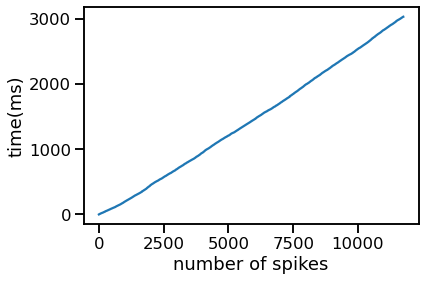

In [15]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)
plt.plot(spikes)
plt.ylabel('time(ms)')
plt.xlabel('number of spikes')

In [16]:
# Get the spiking data for each trial: Epoch an array of spiking data into trials, resetting each trial to start at time 0
all_trials = epoch_spikes_by_range(spikes, move_starts, move_stops, reset=True)


Shuffling spikes: a common techniques to assess statistical significance of observed spike patterns 
- Compare the observed spike patterns with randomly shuffled spike patterns:
    - determine whether the observed pattern are statistically significant or simply due to chance
- Hypothesis testing: determine whether there is a significant relationship between the spiking activity and other variable of interest 
    - for example: spatial bins 
- Randomization control: 
    - control for potential confounding factors or biases in the data 

- Generate surrogate data: 
    - generate surrogate data for testing and validation 

In [17]:
# Create shuffled time series for comparison: 25 shuffles 
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

#### Mask (response time or object appear time)

In [18]:
obj = nwbfile.trials['object'].data[:]

In [19]:
#mask = group_array_by_key(obj, res_time)
mask = group_array_by_key(obj, obj_appear_time)
barrel =  np.array(mask[b'barrel'][:])
box =  np.array(mask[b'box'][:])
bench =  np.array(mask[b'bench'][:])
desk =  np.array(mask[b'desk'][:])
barrel.shape

(16,)

#### Bins

In [20]:
# Compute bin edges
bin_edges = compute_bin_edges(positions, bins)
bin_edges

array([-33.9997    , -32.28243375, -30.5651675 , -28.84790125,
       -27.130635  , -25.41336875, -23.6961025 , -21.97883625,
       -20.26157   , -18.54430375, -16.8270375 , -15.10977125,
       -13.392505  , -11.67523875,  -9.9579725 ,  -8.24070625,
        -6.52344   ,  -4.80617375,  -3.0889075 ,  -1.37164125,
         0.345625  ,   2.06289125,   3.7801575 ,   5.49742375,
         7.21469   ,   8.93195625,  10.6492225 ,  12.36648875,
        14.083755  ,  15.80102125,  17.5182875 ,  19.23555375,
        20.95282   ,  22.67008625,  24.3873525 ,  26.10461875,
        27.821885  ,  29.53915125,  31.2564175 ,  32.97368375,
        34.69095   ])

In [48]:
# Get position values for each spike
spike_positions = get_values_by_times(ptimes, positions, spikes,threshold = 0.1)
spike_times = get_values_by_times(ptimes, ptimes, spikes, threshold=0.1)


(2810,)

In [22]:

# Compute occupancy
occ_kwargs = {'minimum' : min_occ, 'set_nan' : True}
occ = compute_occupancy(positions, ptimes, bins, track_range,
                        speed, speed_thresh, time_thresh, **occ_kwargs)

occ

/Users/weijiazhang/miniconda3/lib/python3.9/site-packages/spiketools/utils/checks.py:248: UserWarning: The data values extend beyond the given bin definition.
  warnings.warn(msg)


array([48.89705444, 21.09872852, 19.59881982, 20.49876562, 17.99891602,
       18.59887842, 19.89880176, 17.7989248 , 17.29896069, 17.39895337,
       17.59893774, 17.69893457, 16.19902368, 15.09909204, 13.79916846,
       15.0990918 , 15.29907593, 15.19908545, 16.3990127 , 15.99903564,
       15.69905518, 16.19902222, 15.69905518, 14.99909619, 14.89910278,
       15.89904248, 16.0990293 , 18.79886694, 19.09885083, 20.19878394,
       20.09878955, 19.5988186 , 20.19878247, 19.69881567, 19.89879858,
       19.59882056, 18.99885425, 14.7991106 ,  4.59972192,         nan])

In [23]:
# Compute spatial bin assignments & binned firing
place_bins = compute_bin_counts_pos(spike_positions, bins, track_range)
place_bins

array([255,  73,  70,  90,  81,  83,  86,  57,  52,  61,  67,  65,  58,
        54,  43,  57,  61,  56,  73,  75,  58,  51,  65,  57,  59,  69,
        69,  81,  68,  86,  79,  82,  76,  82,  73,  92,  88,  78,  39,
         4])

In [24]:
# Compute spatial bin assignments & binned firing, normalized
place_bins_norm = compute_bin_counts_pos(spike_positions, bins, track_range,occ)
place_bins_norm

array([5.21503806, 3.45992413, 3.57164363, 4.39050827, 4.50027101,
       4.46263469, 4.32186827, 3.20244063, 3.00596093, 3.50595801,
       3.80704796, 3.67253745, 3.5804627 , 3.57637399, 3.1161298 ,
       3.77506149, 3.98716892, 3.68443221, 4.4514875 , 4.68778254,
       3.69448985, 3.14833817, 4.14037656, 3.80022898, 3.95997   ,
       4.339884  , 4.2859727 , 4.30877032, 3.56042364, 4.25768206,
       3.93058496, 4.18392566, 3.76260302, 4.1626868 , 3.66856319,
       4.69416003, 4.63185826, 5.27058701, 8.47877342,        nan])

In [25]:
# Compute edges for object / subject position bining 

### Subject response - For each individual object

In [26]:
# Initialize results store
results = {}

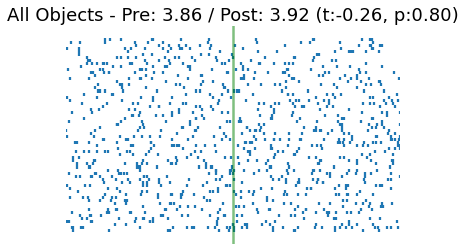

In [27]:
all_objects = epoch_spikes_by_event(spikes, res_time, trial_range)
barrel_trials = epoch_spikes_by_event(spikes, barrel, trial_range)
box_trials = epoch_spikes_by_event(spikes, box, trial_range)
bench_trials = epoch_spikes_by_event(spikes, bench, trial_range)
desk_trials = epoch_spikes_by_event(spikes, desk, trial_range)

fr_pre_all, fr_post_all, results['fr_t_val_all'], results['fr_p_val_all'] = \
    compare_pre_post_activity(all_objects, pre_window, post_window)

# # 10: chest related firing
# plot_rasters(all_objects, xlim=trial_range, vline=0, 
#              title=create_raster_title('All Objects', fr_pre_all, fr_post_all, 
#                  results['fr_t_val_all'], results['fr_p_val_all']),
#              title_color=color_pvalue(results['fr_p_val_all']))

fr_pre_barrel, fr_post_barrel, results['t_val_barrel'], results['p_val_barrel'] = \
compare_pre_post_activity(barrel_trials, pre_window, post_window)

fr_pre_box, fr_post_box, results['t_val_box'], results['p_val_box'] = \
compare_pre_post_activity(box_trials, pre_window, post_window)

fr_pre_bench, fr_post_bench, results['t_val_bench'], results['p_val_bench'] = \
compare_pre_post_activity(bench_trials, pre_window, post_window)

fr_pre_desk, fr_post_desk, results['t_val_desk'], results['p_val_desk'] = \
compare_pre_post_activity(desk_trials, pre_window, post_window)


# avg_pre_box, avg_post_box, t_val_box, p_val_box = compare_pre_post_activity(box_trials, pre_window, post_window)

# bench_trials = epoch_spikes_by_event(spikes, bench, trial_range)
# avg_pre_bench, avg_post_bench, t_val_bench, p_val_bench = compare_pre_post_activity(bench_trials, pre_window, post_window)


# desk_trials = epoch_spikes_by_event(spikes, desk, trial_range)
# avg_pre_desk, avg_post_desk, t_val_desk, p_val_desk = compare_pre_post_activity(desk_trials, pre_window, post_window)


In [74]:

# plot_rasters(barrel_trials, xlim=trial_range, vline=0,
#              title=create_raster_title('Barrel', fr_pre_barrel, fr_post_barrel,
#                  results['t_val_barrel'], results['p_val_barrel']),
#              title_color=color_pvalue(results['p_val_barrel']), title_fontsize=14,
#              )
# plot_rasters(bench_trials, xlim=trial_range, vline=0, 
#              title=create_raster_title('Bench', fr_pre_bench, fr_post_bench,
#                  results['t_val_bench'], results['p_val_bench']),
#              title_color=color_pvalue(results['p_val_bench']), title_fontsize=14,
#              )
# plot_rasters(box_trials, xlim=trial_range, vline=0,
#              title=create_raster_title('Box', fr_pre_box, fr_post_box,
#                  results['t_val_box'], results['p_val_box']),
#              title_color=color_pvalue(results['p_val_box']), title_fontsize=14,
#              )
# plot_rasters(desk_trials, xlim=trial_range, vline=0, 
#              title=create_raster_title('Desk', fr_pre_desk, fr_post_desk,
#                  results['t_val_desk'], results['p_val_desk']),
#              title_color=color_pvalue(results['p_val_desk']), title_fontsize=14,
#              )


## Place Cell Analysis:

In [29]:
# Place cell analysis
if 'INFO' in METHODS['PLACE']:
    # This measure computes the spatial information between the firing and spatial location 
    results['place_info'] = compute_spatial_information(place_bins,occ)
    
if 'ANOVA' in METHODS['PLACE']:
    # The spike activity per spatial bin, per trial
    place_trial = compute_trial_place_bins(spikes, positions, ptimes, bins, move_starts, move_stops, 
                                           track_range, speed, speed_thresh, time_thresh)
    results['place_anova'] = fit_anova_place(create_df_place(place_trial))
    

### Surrogates

In [30]:
# Collect list of which analyses are being run for surrogates, and initialize surrogate stores
surr_analyses = create_methods_list(METHODS)
surrs = {analysis : np.zeros(n_surrogates) for analysis in surr_analyses}

In [31]:
surr_analyses

['place_anova', 'place_info']

In [32]:
# Compute surrogate measures
for ind, shuffle in enumerate(times_shuffle):    
    
    # PLACE
    if 'INFO' in METHODS['PLACE']:
        surr_place_bins = compute_place_bins(shuffle, positions, ptimes, bins, 
                                             track_range, speed, speed_thresh, time_thresh)
        surrs['place_info'][ind] = compute_spatial_information(surr_place_bins, occ, normalize=True)
    if 'ANOVA' in METHODS['PLACE']:
        surr_place_trial = compute_trial_place_bins(shuffle, positions, ptimes, bins,
                                                    move_starts, move_stops, track_range,
                                                    speed, speed_thresh, time_thresh,
                                                    flatten=True)
        surrs['place_anova'][ind] = fit_anova_place(create_df_place(surr_place_trial))
    

In [33]:
# Compute surrogate statistics
for analysis in surr_analyses:
    results[analysis + '_surr_p_val'], results[analysis + '_surr_z_score'] = \
        compute_surrogate_stats(results[analysis], surrs[analysis])

## Create Report

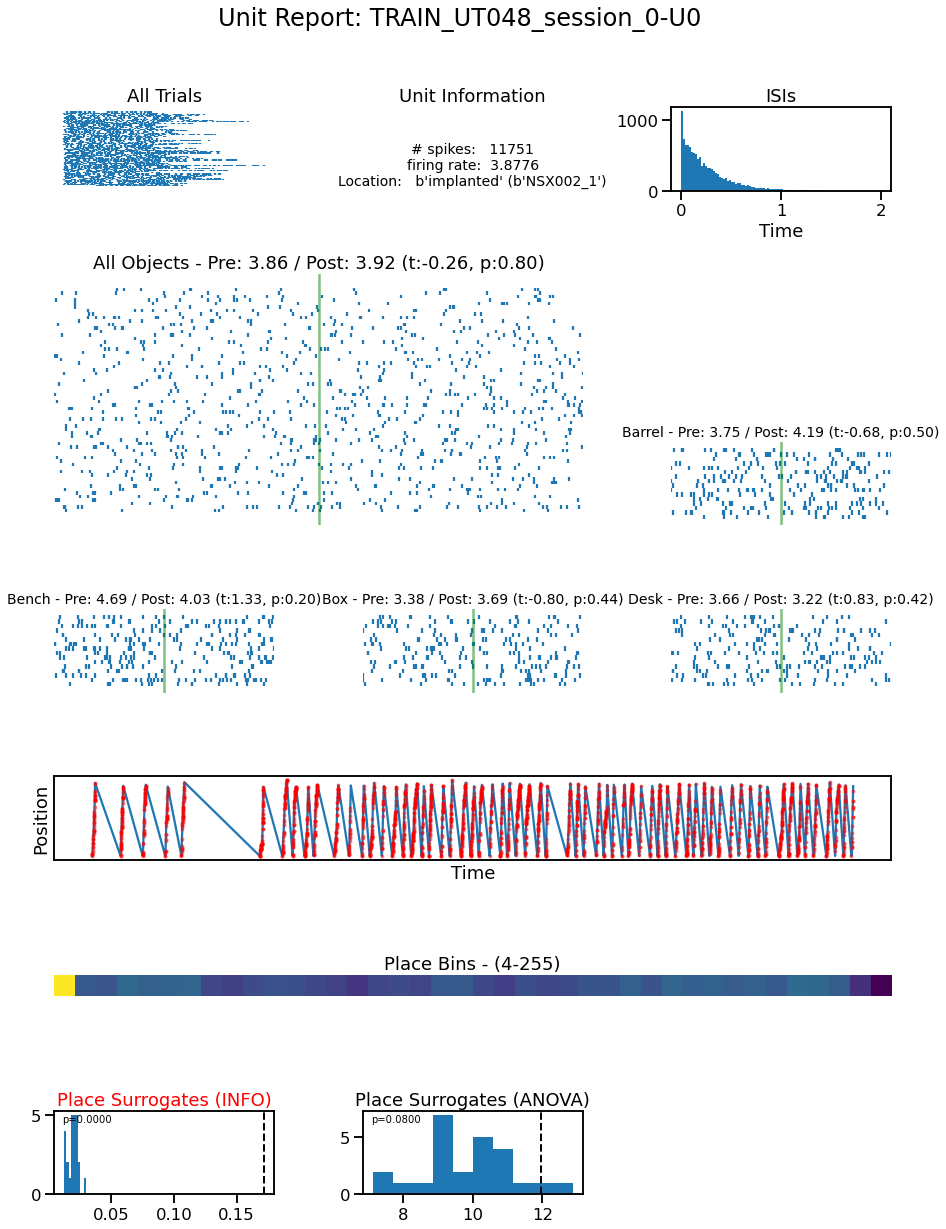

In [73]:
# Initialize figure with grid layout
grid = make_grid(7, 3, figsize=(15, 20), wspace=0.4, hspace=1.,
                 title='Unit Report: {}-U{}'.format(nwbfile.session_id, uind))

# 00: plot rasters across all trials
plot_rasters(all_trials, title='All Trials', ax=get_grid_subplot(grid, 0, 0))

# 01: unit information
plot_text(create_unit_str(create_unit_info(nwbfile.units[uind])),
          title='Unit Information', ax=get_grid_subplot(grid, 0, 1))

# 02: inter-spike intervals
plot_isis(compute_isis(spikes), bins=100, range=(0, 2), ax=get_grid_subplot(grid, 0, 2))

# 10: object related firing
plot_rasters(all_objects, xlim=trial_range, vline=0, 
             title=create_raster_title('All Objects', fr_pre_all, fr_post_all, 
                 results['fr_t_val_all'], results['fr_p_val_all']),
             title_color=color_pvalue(results['fr_p_val_all']),
             ax=get_grid_subplot(grid, slice(1, 3), slice(0, 2)))


plot_rasters(barrel_trials, xlim=trial_range, vline=0,
             title=create_raster_title('Barrel', fr_pre_barrel, fr_post_barrel,
                 results['t_val_barrel'], results['p_val_barrel']),
             title_color=color_pvalue(results['p_val_barrel']), title_fontsize=14, 
             ax=get_grid_subplot(grid, slice(2, 3), slice(2, 3))
             )

plot_rasters(bench_trials, xlim=trial_range, vline=0, 
             title=create_raster_title('Bench', fr_pre_bench, fr_post_bench,
                 results['t_val_bench'], results['p_val_bench']),
             title_color=color_pvalue(results['p_val_bench']), title_fontsize=14,
             ax=get_grid_subplot(grid, 3, 0))
plot_rasters(box_trials, xlim=trial_range, vline=0,
             title=create_raster_title('Box', fr_pre_box, fr_post_box,
                 results['t_val_box'], results['p_val_box']),
             title_color=color_pvalue(results['p_val_box']), title_fontsize=14,
             ax=get_grid_subplot(grid, 3, 1))
plot_rasters(desk_trials, xlim=trial_range, vline=0, 
             title=create_raster_title('Desk', fr_pre_desk, fr_post_desk,
                 results['t_val_desk'], results['p_val_desk']),
             title_color=color_pvalue(results['p_val_desk']), title_fontsize=14,
              ax=get_grid_subplot(grid, 3, 2))


# ax30: positional firing
plot_position_by_time(ptimes,positions,spike_times,spike_positions,alpha=1,ax=get_grid_subplot(grid, 4, slice(0, 3)))

# ax31: positional heatmap
plot_heatmap(place_bins, ax=get_grid_subplot(grid, 5, slice(0, 3)), 
             title=create_heat_title('Place Bins', place_bins))


# ax32: place surrogates (info)
if 'INFO' in METHODS['PLACE']:
    plot_surrogates(surrs['place_info'], results['place_info'], results['place_info_surr_p_val'],
                    title='Place Surrogates (INFO)',
                    title_color=color_pvalue(results['place_info_surr_p_val']),
                    ax=get_grid_subplot(grid, 6, slice(0, 1)))

    
# ax42: place surrogates (anova)
if 'ANOVA' in METHODS['PLACE']:
    plot_surrogates(surrs['place_anova'], results['place_anova'], results['place_anova_surr_p_val'],
                    title='Place Surrogates (ANOVA)',
                    title_color=color_pvalue(results['place_anova_surr_p_val']),
                   ax=get_grid_subplot(grid, 6, slice(1, 2)))


In [ ]:
## TODO:
#1. check edge bins 
#2. Turn this report into runing every cell, statistical analysis for each cells 
#3. Github PR 
#4. Single Trial plots on top of each other
#5. Clean up the notebooks 